# Install Transformers Library

In [ ]:
!git clone https://github.com/aub-mind/arabert.git

Cloning into 'arabert'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 530 (delta 167), reused 226 (delta 82), pack-reused 214
Receiving objects: 100% (530/530), 4.86 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (290/290), done.


In [ ]:
pip install pyarabic

     |████████████████████████████████| 133kB 8.7MB/s 


In [ ]:
pip install farasapy

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 8.8MB/s 
     |████████████████████████████████| 901kB 55.9MB/s 
     |████████████████████████████████| 3.3MB 32.8MB/s 


In [ ]:
pip install neattext

     |████████████████████████████████| 112kB 7.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import string #Opérations courantes sur les chaînes
import re   # pour utiliser  des expressions régulières ex:$
import nltk #boites outils ntk
import neattext as nt
import neattext.functions as nfx
from neattext import TextCleaner as tc

# specify GPU
device = torch.device("cuda")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Dataset

In [ ]:
#Importer le fichier excel
df=pd.read_excel('new_db.xlsx') #filename:le chemin d'acces au fichier excel

In [ ]:
df

,TWEET,LABEL
0,الاوليمبياد الجايه هكون لسه ف الكليه,0
1,عجز الموازنه وصل ل937 من الناتج المحلي يعني لس...,1
2,كتنا نيله ف حظنا الهباب,2
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,3
4,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...,0
...,...,...
29964,اتمني تعملو بطاقات خاصة او ذهبية لعملاء الداءم...,3
29965,المشويات عندهم اطيب مشويات اكلتها بحياتي والاس...,3
29966,المطعم متاز لغايه من ناحيه تجهيزات المطعم وايض...,3
29967,جينا عندهم الساعة 10 باليل مافي احد اتبرع يشوف...,1


In [ ]:
#Cleaning & Preprocessing
def process(text):
# la normalisation
    regex = re.compile(r'[إأٱآا]') #sauvegarder l'expression réguliere (r=expression reguliere)
    text = re.sub(regex, 'ا', str(text)) #remblacer des expressions par d'autres dans varia texte
    regex = re.compile(r'[ى]')
    text = re.sub(regex, 'ي', str(text))
    regex = re.compile(r'[ؤئ]')
    text = re.sub(regex, 'ء', str(text))
    text = re.sub('\n', ' ', str(text))
    text = re.sub(' و ', ' ', str(text))
    text = re.sub(r'\s*[A-Za-z]+\b', '' , text)
    text = text.rstrip()
#supprimer les diacritiques
    arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)   #verbose: séparer visuellement les expre et ajouter des commentaires
    text = re.sub(arabic_diacritics, '', text)
    

#supprimer les ponctuations
    #liste des ponctuations arabe et anglais qu'on veut supprimer
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''    # utiliser ''' :multiples caractére de chaine
    english_punctuations = string.punctuation              #(!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~)
    punctuations_list = arabic_punctuations + english_punctuations
    #table de mappage
    translator = str.maketrans('','', punctuations_list) # le 1er elem a remplacer/le 2eme le remplacement,3eme=supprimer
    text= text.translate(translator) #chaine ou les caractere sont remplacé par d'autres dns table de mappage

#supprimer les chaines répétés
    text=re.sub(r'(.)\1+', r'\1', str(text)) 

#supprimer les mots vides
    stopwords=nltk.corpus.stopwords.words('arabic') #les mots vides en arabe
    txt=[word for word in text if word not in stopwords]

#supprimer les émojis
    myre = re.compile(u'['
    u'\U0001F300-\U0001F64F'
    u'\U0001F680-\U0001F6FF'     
    u'\u2600-\u26FF\u2700-\u27BF]+', re.UNICODE)
    text=myre.sub('', text)
    
    
    return text

In [ ]:
#Afficher les labels de la bd
df.LABEL.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
# check class distribution
df['LABEL'].value_counts(normalize = True)

3    0.408856
1    0.190063
2    0.117321
4    0.081551
5    0.064100
0    0.057059
7    0.042377
6    0.038673
Name: LABEL, dtype: float64

In [ ]:
df= df.rename(columns={'LABEL': 'label'})
df= df.rename(columns={'TWEET': 'text'})

In [ ]:
#Cleaning DB
df['text'] = df['text'].apply(process)
df['text']=df['text'].apply(nfx.remove_hashtags)
df['text']=df['text'].apply(nfx.remove_userhandles)

In [ ]:
df

,text,label
0,الاوليمبياد الجايه هكون لسه ف الكليه,0
1,عجز الموازنه وصل ل937 من الناتج المحلي يعني لس...,1
2,كتنا نيله ف حظنا الهباب,2
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,3
4,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...,0
...,...,...
29964,اتمني تعملو بطاقات خاصة او ذهبية لعملاء الداءم...,3
29965,المشويات عندهم اطيب مشويات اكلتها بحياتي والاس...,3
29966,المطعم متاز لغايه من ناحيه تجهيزات المطعم وايض...,3
29967,جينا عندهم الساعة 10 باليل مافي احد اتبرع يشوف...,1


In [ ]:
df.shape

(29969, 2)

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, test_size=0.8)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('aubmindlab/bert-base-arabertv02')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabertv02')

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenization

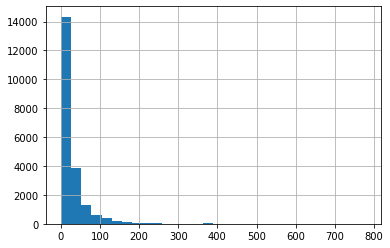

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 40

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,8)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters())

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[2.16714876 0.65951962 1.05608135 0.30573044 1.53797654 2.00171756
 3.19397077 2.9266183 ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
 
# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
 
# number of training epochs
epochs = 15

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()
 
  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
 
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
 
    # clear previously calculated gradients 
    model.zero_grad()        
 
    # get model predictions for the current batch
    preds = model(sent_id, mask)
 
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
 
    # add on to the total loss
    total_loss = total_loss + loss.item()
 
    # backward pass to calculate the gradients
    loss.backward()
 
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
    # update parameters
    optimizer.step()
 
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
 
    # append the model predictions
    total_preds.append(preds)
 
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
 
  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    656.
  Batch   100  of    656.
  Batch   150  of    656.
  Batch   200  of    656.
  Batch   250  of    656.
  Batch   300  of    656.
  Batch   350  of    656.
  Batch   400  of    656.
  Batch   450  of    656.
  Batch   500  of    656.
  Batch   550  of    656.
  Batch   600  of    656.
  Batch   650  of    656.

Evaluating...
  Batch    50  of     57.

Training Loss: 1.453
Validation Loss: 1.292

 Epoch 2 / 15
  Batch    50  of    656.
  Batch   100  of    656.
  Batch   150  of    656.
  Batch   200  of    656.
  Batch   250  of    656.
  Batch   300  of    656.
  Batch   350  of    656.
  Batch   400  of    656.
  Batch   450  of    656.
  Batch   500  of    656.
  Batch   550  of    656.
  Batch   600  of    656.
  Batch   650  of    656.

Evaluating...
  Batch    50  of     57.

Training Loss: 1.305
Validation Loss: 1.266

 Epoch 3 / 15
  Batch    50  of    656.
  Batch   100  of    656.
  Batch   150  of    656.
  Batch   200  of    656.
  B

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:

test_y.shape

torch.Size([7193])

In [ ]:
# get predictions for test data
pr=np.zeros((7193, 8))
for i in range(0,7193):
  with torch.no_grad():
    preds = model(test_seq[i:i+1].to(device), test_mask[i:i+1].to(device))
    preds = preds.detach().cpu().numpy()
  pr[i]=preds

In [ ]:
# model's performance
preds = np.argmax(pr, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.50      0.88      0.63       401
           1       0.57      0.44      0.50      1360
           2       0.40      0.40      0.40       830
           3       0.78      0.68      0.73      2945
           4       0.33      0.33      0.33       590
           5       0.50      0.59      0.54       501
           6       0.53      0.82      0.64       273
           7       0.56      0.80      0.66       293

    accuracy                           0.59      7193
   macro avg       0.52      0.62      0.55      7193
weighted avg       0.60      0.59      0.59      7193



In [ ]:
#([0,1,2,3,4,5,6,7],['none', 'anger', 'sadness', 'joy', 'surprise', 'love', 'sympathy','fear'])

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6,7
row_0,,,,,,,,
0,351,6,7,16,15,2,1,3
1,58,605,215,230,130,46,38,38
2,70,104,332,118,55,53,40,58
3,120,236,181,2008,162,153,59,26
4,87,72,56,115,192,19,10,39
5,7,36,26,83,7,295,37,10
6,4,6,5,7,5,15,224,7
7,11,4,6,4,14,8,13,233
